<a href="https://colab.research.google.com/github/MuhammedHaleef/Defense-Mechanisms-in-Adversarial-Attacks---Implementations/blob/main/DiffPure_test_Arfadh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run as a Colab code cell.
!pip install --upgrade pip setuptools wheel
# Install PyTorch (CUDA 11.8 wheel on Colab)
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
# Pin diffusers + compatible huggingface_hub version to avoid the cached_download import error
!pip install diffusers==0.25.0 huggingface_hub==0.21.3
# Other utilities
!pip install transformers accelerate safetensors matplotlib tqdm autoattack


Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.8 MB/s  0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.35.2
    Uninstalling diffusers-0.35.2:
      Successfully uninstalled diffusers-0.35.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [diffusers]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.21.3 which is incompatible.
transformers 4.57.2 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 0.21.3 which is incompatible.
peft 0.18.0 requires huggingface_hub>=0.25.0, bu

In [ ]:
# Run after runtime restart
# Fix: The diffusers library requires huggingface_hub version >= 0.34.0 and < 1.0.
# The previous installation pinned it to 0.21.3, causing an incompatibility.
# We will upgrade huggingface_hub here. After running this cell, please restart the runtime
# (Runtime -> Restart runtime) for the changes to take effect.
!pip install huggingface_hub==0.34.0 --force-reinstall

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from diffusers import DDPMPipeline, DDIMScheduler
print("torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.7/558.7 kB 17.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 46.5 MB/s  0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.3
    Uninstalling PyYAML-6.0.3:
      Successfully uninstalled PyYAML-6.0.3
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
 

KeyboardInterrupt: 

In [ ]:
# CIFAR-10 normalization params (for classifier)
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
transform_plain = transforms.Compose([transforms.ToTensor()])  # for underlying pixel-handling when needed

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testset_plain = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_plain)  # same ordering
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
testloader_small = DataLoader(testset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
print("Testset size:", len(testset))


NameError: name 'transforms' is not defined

In [ ]:
# Build CIFAR-adapted ResNet18
def get_resnet18_cifar():
    model = resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

clf = get_resnet18_cifar().to(device)

# Download a ready-made CIFAR-10 ResNet18 checkpoint (community checkpoint)
import urllib.request, os
ckpt_url = "https://github.com/huyvnphan/PyTorch_CIFAR10/raw/master/cifar10_resnet18.pth"
ckpt_path = "cifar10_resnet18.pth"
if not os.path.exists(ckpt_path):
    print("Downloading classifier checkpoint...")
    urllib.request.urlretrieve(ckpt_url, ckpt_path)
else:
    print("Classifier checkpoint already exists.")

state = torch.load(ckpt_path, map_location='cpu')
try:
    clf.load_state_dict(state)
    print("Loaded classifier checkpoint.")
except Exception as e:
    # some checkpoints contain extra keys - attempt flexible load
    from collections import OrderedDict
    new_state = OrderedDict()
    for k,v in state.items():
        if k.startswith('module.'):
            new_state[k[len('module.'):]] = v
        else:
            new_state[k] = v
    clf.load_state_dict(new_state)
    print("Loaded classifier checkpoint with adjusted keys.")

clf.eval()
# quick sanity check on a small batch (no grad)
x, y = next(iter(testloader_small))
x, y = x.to(device), y.to(device)
with torch.no_grad():
    preds = clf(x).argmax(dim=1)
print("Sample classifier preds:", preds.cpu().numpy())


In [ ]:
# Load DDPM pipeline and set to GPU
print("Loading DDPM pipeline (this downloads model ~200MB)...")
ddpm = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
# set a DDIMScheduler for potential faster sampling if desired (we will use ddpm.scheduler for default)
ddpm.scheduler = ddpm.scheduler  # keep default DDPM scheduler
ddpm = ddpm.to(device)
unet = ddpm.unet
scheduler = ddpm.scheduler
print("DDPM loaded. timesteps:", scheduler.num_train_timesteps)


In [ ]:
# Tensors for conversion
mean_t = torch.tensor(mean, device=device).view(1,3,1,1)
std_t  = torch.tensor(std, device=device).view(1,3,1,1)

def normalized_to_pixel(x_norm):
    # x_norm: normalized w.r.t mean/std -> pixel [0,1]
    return (x_norm * std_t + mean_t).clamp(0.0,1.0)

def pixel_to_normalized(x_pixel):
    return (x_pixel - mean_t) / std_t

# q_sample for DDPM forward diffusion (returns sample in model space [-1,1])
alphas_cumprod = scheduler.alphas_cumprod.to(device)  # shape [num_train_timesteps]
def q_sample(x0_pixel, t):
    """
    x0_pixel: [B,3,32,32] in [0,1]
    t: integer timestep (0 .. num_train_timesteps-1)
    returns x_t in model space ([-1,1]) and the noise added
    """
    # Map pixel [0,1] to model input space [-1,1]
    x0 = x0_pixel * 2.0 - 1.0
    a = alphas_cumprod[t]
    noise = torch.randn_like(x0)
    x_t = torch.sqrt(a) * x0 + torch.sqrt(1 - a) * noise
    return x_t, noise


In [ ]:
def pgd_linf_classifier(model, x_norm, y, eps=8/255, alpha=2/255, iters=10):
    """
    model: classifier expects normalized input
    x_norm: normalized images (batch) [B,3,32,32]
    returns: adversarial images in normalized space
    """
    model.eval()
    # convert to pixel [0,1]
    x_pixel = normalized_to_pixel(x_norm).detach()
    x_adv = x_pixel + torch.empty_like(x_pixel).uniform_(-eps, eps)
    x_adv = x_adv.clamp(0.0, 1.0)

    mean_t_local = mean_t
    std_t_local = std_t

    for i in range(iters):
        x_adv.requires_grad_()
        x_adv_norm = (x_adv - mean_t_local) / std_t_local
        logits = model(x_adv_norm)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = x_adv.grad.detach()
        x_adv = (x_adv + alpha * torch.sign(grad)).detach()
        # Project back to eps-ball around original pixel
        x_adv = torch.max(torch.min(x_adv, x_pixel + eps), x_pixel - eps)
        x_adv = x_adv.clamp(0.0, 1.0)
    return (x_adv - mean_t_local) / std_t_local


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# If CPU only:
# !pip install torch torchvision torchaudio

!pip install tqdm einops


Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
import os
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from einops import rearrange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Reproducibility
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(42)

# Small-scale config to keep runtime reasonable
BATCH_SIZE = 128
EPOCHS_CLS = 10     # classifier training epochs (adjust if you want higher accuracy)
EPOCHS_DDPM = 10    # diffusion training epochs (enough to demonstrate purification effect)
LR_CLS = 1e-3
LR_DDPM = 2e-4
NUM_WORKERS = 2

IMG_SIZE = 32
NUM_CLASSES = 10


Device: cuda


In [ ]:

# CIFAR-10 normalization stats
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tf)
test_set  = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s]


In [ ]:
def make_resnet18(num_classes=NUM_CLASSES):
    model = models.resnet18(weights=None)
    # Adjust first conv for CIFAR-10 (32x32); keep kernel_size=3, stride=1, padding=1
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # remove maxpool to suit 32x32
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

clf = make_resnet18().to(device)
optimizer = optim.Adam(clf.parameters(), lr=LR_CLS)
criterion = nn.CrossEntropyLoss()


In [ ]:
def train_classifier(model, loader, optimizer, epochs=EPOCHS_CLS):
    model.train()
    for ep in range(epochs):
        total, correct, loss_sum = 0, 0, 0.0
        for x, y in tqdm(loader, desc=f'Classifier Train Epoch {ep+1}/{epochs}'):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)
        print(f'Epoch {ep+1}: loss={loss_sum/total:.4f}, acc={correct/total:.4f}')

def eval_classifier(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    print(f'Test: loss={loss_sum/total:.4f}, acc={correct/total:.4f}')

train_classifier(clf, train_loader, optimizer, epochs=EPOCHS_CLS)
eval_classifier(clf, test_loader)


Classifier Train Epoch 1/10: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s]


Epoch 1: loss=1.3651, acc=0.5001


Classifier Train Epoch 2/10: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s]


Epoch 2: loss=0.8832, acc=0.6869


Classifier Train Epoch 3/10: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s]


Epoch 3: loss=0.6888, acc=0.7591


Classifier Train Epoch 4/10: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s]


Epoch 4: loss=0.5751, acc=0.8002


Classifier Train Epoch 5/10: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s]


Epoch 5: loss=0.5014, acc=0.8271


Classifier Train Epoch 6/10: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s]


Epoch 6: loss=0.4445, acc=0.8470


Classifier Train Epoch 7/10: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s]


Epoch 7: loss=0.4038, acc=0.8601


Classifier Train Epoch 8/10: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s]


Epoch 8: loss=0.3659, acc=0.8727


Classifier Train Epoch 9/10: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s]


Epoch 9: loss=0.3360, acc=0.8842


Classifier Train Epoch 10/10: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s]


Epoch 10: loss=0.3022, acc=0.8938
Test: loss=0.5013, acc=0.8394


In [ ]:
mean = torch.tensor(CIFAR10_MEAN, device=device).view(1,3,1,1)
std  = torch.tensor(CIFAR10_STD, device=device).view(1,3,1,1)

def to_pixel_space(x_norm):
    return torch.clamp(x_norm * std + mean, 0.0, 1.0)

def to_norm_space(x_pix):
    return (x_pix - mean) / std

def pgd_attack(model, x, y, eps=8/255, alpha=2/255, steps=10, random_start=True):
    model.eval()
    x_pix = to_pixel_space(x).detach()
    if random_start:
        x_adv_pix = x_pix + torch.empty_like(x_pix).uniform_(-eps, eps)
        x_adv_pix = torch.clamp(x_adv_pix, 0.0, 1.0)
    else:
        x_adv_pix = x_pix.clone()

    for _ in range(steps):
        x_adv_norm = to_norm_space(x_adv_pix).detach()
        x_adv_norm.requires_grad_(True)
        logits = model(x_adv_norm)
        loss = criterion(logits, y)
        grad = torch.autograd.grad(loss, x_adv_norm)[0]
        # gradient in normalized space, convert to pixel-space step
        step = alpha * torch.sign(grad)
        # move in pixel space (respecting normalization)
        x_adv_pix = x_adv_pix + step * std  # scale by std to align spaces
        # project back to epsilon-ball
        x_adv_pix = torch.min(torch.max(x_adv_pix, x_pix - eps), x_pix + eps)
        x_adv_pix = torch.clamp(x_adv_pix, 0.0, 1.0)

    return to_norm_space(x_adv_pix).detach()

def eval_under_attack(model, loader, **pgd_params):
    model.eval()
    total, correct = 0, 0
    for x, y in tqdm(loader, desc='Evaluating under PGD'):
        x, y = x.to(device), y.to(device)
        x_adv = pgd_attack(model, x, y, **pgd_params)
        logits = model(x_adv)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    print(f'PGD accuracy: {correct/total:.4f}')

# Baseline robustness check
eval_under_attack(clf, test_loader, eps=8/255, alpha=2/255, steps=10, random_start=True)


Evaluating under PGD: 100%|██████████| 79/79 [00:57<00:00,  1.38it/s]

PGD accuracy: 0.0017


In [ ]:
@dataclass
class DiffConfig:
    timesteps: int = 1000  # training discretization
    img_ch: int = 3
    img_size: int = 32
    beta_start: float = 1e-4
    beta_end: float = 0.02

DCONF = DiffConfig()

# Linear beta schedule
betas = torch.linspace(DCONF.beta_start, DCONF.beta_end, DCONF.timesteps, device=device)
alphas = 1.0 - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)
alpha_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alpha_cumprod[:-1]], dim=0)
sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod)
sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - alpha_cumprod)
posterior_variance = betas * (1.0 - alpha_cumprod_prev) / (1.0 - alpha_cumprod)

def extract(a, t, x_shape):
    out = a.gather(-1, t)
    return out.view(-1, 1, 1, 1).expand(x_shape)


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
    def forward(self, x):
        return self.block(x)

class Down(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.down = nn.Conv2d(ch, ch, 3, stride=2, padding=1)
    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(ch, ch, 4, stride=2, padding=1)
    def forward(self, x):
        return self.up(x)

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, dim*4), nn.SiLU(),
            nn.Linear(dim*4, dim)
        )
    def forward(self, t):
        return self.fc(t)

def sinusoidal_time_embedding(t, dim=64):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device) / half)
    angles = t[:, None] * freqs[None, :]
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
    return emb

class SmallUNet(nn.Module):
    def __init__(self, img_ch=3, base=64, time_dim=64):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, base),
            nn.SiLU(),
        )

        self.enc1 = ConvBlock(img_ch, base)
        self.enc2 = ConvBlock(base, base*2)
        self.enc3 = ConvBlock(base*2, base*2)

        self.down1 = Down(base)
        self.down2 = Down(base*2)

        self.mid = ConvBlock(base*2, base*2)

        self.up2 = Up(base*2)
        self.dec2 = ConvBlock(base*2, base)
        self.up1 = Up(base)
        self.dec1 = ConvBlock(base, base)

        self.out = nn.Conv2d(base, img_ch, 1)

    def forward(self, x, t):
        # t: (B,) in [0, T-1]
        t = t.float()
        te = sinusoidal_time_embedding(t, 64)
        te = self.time_mlp(te)

        h1 = self.enc1(x)
        h2 = self.down1(h1)
        h2 = self.enc2(h2)
        h3 = self.down2(h2)
        h3 = self.enc3(h3)

        m = self.mid(h3 + te[:, :, None, None])

        u2 = self.up2(m)
        d2 = self.dec2(u2 + h2)
        u1 = self.up1(d2)
        d1 = self.dec1(u1 + h1)

        out = self.out(d1)
        return out


In [ ]:
# Redefine SmallUNet with the fix to the time_mlp layer.
# This redefinition is placed here to adhere to the instruction to modify *only* this cell.
# The ideal fix would be to modify the original definition in cell '6pGIua4qatC0'.
class SmallUNet(nn.Module):
    def __init__(self, img_ch=3, base=64, time_dim=64):
        super().__init__()
        # Fix: The time embedding output dimension must match the channels of h3 (base*2)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, base * 2), # Changed from 'base' to 'base * 2'
            nn.SiLU(),
        )

        self.enc1 = ConvBlock(img_ch, base)
        self.enc2 = ConvBlock(base, base*2)
        self.enc3 = ConvBlock(base*2, base*2)

        self.down1 = Down(base)
        self.down2 = Down(base*2)

        self.mid = ConvBlock(base*2, base*2)

        self.up2 = Up(base*2)
        self.dec2 = ConvBlock(base*2, base)
        self.up1 = Up(base)
        self.dec1 = ConvBlock(base, base)

        self.out = nn.Conv2d(base, img_ch, 1)

    def forward(self, x, t):
        # t: (B,) in [0, T-1]
        t = t.float()
        # sinusoidal_time_embedding is defined in cell 6pGIua4qatC0 and used here.
        te = sinusoidal_time_embedding(t, 64)
        te = self.time_mlp(te)

        h1 = self.enc1(x)
        h2 = self.down1(h1)
        h2 = self.enc2(h2)
        h3 = self.down2(h2)
        h3 = self.enc3(h3)

        # The error occurred here due to mismatching channel dimensions between h3 and te
        m = self.mid(h3 + te[:, :, None, None])

        u2 = self.up2(m)
        d2 = self.dec2(u2 + h2)
        u1 = self.up1(d2)
        d1 = self.dec1(u1 + h1)

        out = self.out(d1)
        return out

train_tf_pix = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # no normalization for diffusion
])

train_set_pix = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tf_pix)
train_loader_pix = DataLoader(train_set_pix, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

ddpm = SmallUNet(img_ch=3, base=64).to(device)
opt_ddpm = optim.AdamW(ddpm.parameters(), lr=LR_DDPM)

def ddpm_train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    count = 0
    for x, _ in tqdm(loader, desc='DDPM Train'):
        x = x.to(device)  # pixel space [0,1]
        t = torch.randint(0, DCONF.timesteps, (x.size(0),), device=device, dtype=torch.long)
        noise = torch.randn_like(x)
        x_t = extract(sqrt_alpha_cumprod, t, x.shape) * x + extract(sqrt_one_minus_alpha_cumprod, t, x.shape) * noise
        pred_noise = model(x_t, t)
        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        count += x.size(0)
    return total_loss / count

for ep in range(EPOCHS_DDPM):
    l = ddpm_train_epoch(ddpm, train_loader_pix, opt_ddpm)
    print(f'DDPM epoch {ep+1}/{EPOCHS_DDPM} - loss: {l:.4f}')


DDPM Train: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]


DDPM epoch 1/10 - loss: 0.0884


DDPM Train: 100%|██████████| 391/391 [00:29<00:00, 13.45it/s]


DDPM epoch 2/10 - loss: 0.0331


DDPM Train: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s]


DDPM epoch 3/10 - loss: 0.0284


DDPM Train: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]


DDPM epoch 4/10 - loss: 0.0262


DDPM Train: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s]


DDPM epoch 5/10 - loss: 0.0247


DDPM Train: 100%|██████████| 391/391 [00:28<00:00, 13.55it/s]


DDPM epoch 6/10 - loss: 0.0238


DDPM Train: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s]


DDPM epoch 7/10 - loss: 0.0228


DDPM Train: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]


DDPM epoch 8/10 - loss: 0.0222


DDPM Train: 100%|██████████| 391/391 [00:28<00:00, 13.52it/s]


DDPM epoch 9/10 - loss: 0.0222


DDPM Train: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s]

DDPM epoch 10/10 - loss: 0.0215


In [ ]:
@torch.no_grad()
def ddim_reverse(model, x_t, start_t, end_t=0, steps=50):
    # Create a schedule of timesteps from start_t down to end_t
    ts = torch.linspace(start_t, end_t, steps, device=device).long()
    x = x_t
    for i in range(steps):
        t = ts[i].clamp(0, DCONF.timesteps-1)
        # predict noise at timestep t
        eps = model(x, t)
        a_t = extract(alpha_cumprod, t, x.shape)
        sqrt_a_t = torch.sqrt(a_t)
        sqrt_one_minus_a_t = torch.sqrt(1 - a_t)
        x0_pred = (x - sqrt_one_minus_a_t * eps) / (sqrt_a_t + 1e-8)
        if i == steps - 1:
            x = x0_pred
        else:
            t_next = ts[i+1].clamp(0, DCONF.timesteps-1)
            a_next = extract(alpha_cumprod, t_next, x.shape)
            sqrt_a_next = torch.sqrt(a_next)
            # deterministic (eta=0) DDIM update
            x = sqrt_a_next * x0_pred + torch.sqrt(1 - a_next) * eps
        x = torch.clamp(x, 0.0, 1.0)
    return x

@torch.no_grad()
def purify_adversarial(model, x_adv_norm, start_t=400, steps=50):
    # Convert adv example to pixel space
    x_adv_pix = to_pixel_space(x_adv_norm)
    # Forward diffuse to chosen start_t
    t = torch.full((x_adv_pix.size(0),), start_t, device=device, dtype=torch.long)
    noise = torch.randn_like(x_adv_pix)
    x_t = extract(sqrt_alpha_cumprod, t, x_adv_pix.shape) * x_adv_pix + extract(sqrt_one_minus_alpha_cumprod, t, x_adv_pix.shape) * noise
    # Reverse with DDIM
    x_pur_pix = ddim_reverse(ddpm, x_t, start_t=start_t, end_t=0, steps=steps)
    # Back to normalized space for classifier
    x_pur_norm = to_norm_space(x_pur_pix)
    return x_pur_norm


In [ ]:
@torch.no_grad()
def ddim_reverse(model, x_t, start_t, end_t=0, steps=50):
    # Create a schedule of timesteps from start_t down to end_t
    ts = torch.linspace(start_t, end_t, steps, device=device).long()
    x = x_t
    for i in range(steps):
        t = ts[i].clamp(0, DCONF.timesteps-1)
        # predict noise at timestep t
        # FIX: unsqueeze t to provide a batch dimension for sinusoidal_time_embedding
        eps = model(x, t.unsqueeze(0))
        a_t = extract(alpha_cumprod, t, x.shape)
        sqrt_a_t = torch.sqrt(a_t)
        sqrt_one_minus_a_t = torch.sqrt(1 - a_t)
        x0_pred = (x - sqrt_one_minus_a_t * eps) / (sqrt_a_t + 1e-8)
        if i == steps - 1:
            x = x0_pred
        else:
            t_next = ts[i+1].clamp(0, DCONF.timesteps-1)
            a_next = extract(alpha_cumprod, t_next, x.shape)
            sqrt_a_next = torch.sqrt(a_next)
            # deterministic (eta=0) DDIM update
            x = sqrt_a_next * x0_pred + torch.sqrt(1 - a_next) * eps
        x = torch.clamp(x, 0.0, 1.0)
    return x

@torch.no_grad()
def purify_adversarial(model, x_adv_norm, start_t=400, steps=50):
    # Convert adv example to pixel space
    x_adv_pix = to_pixel_space(x_adv_norm)
    # Forward diffuse to chosen start_t
    t = torch.full((x_adv_pix.size(0),), start_t, device=device, dtype=torch.long)
    noise = torch.randn_like(x_adv_pix)
    x_t = extract(sqrt_alpha_cumprod, t, x_adv_pix.shape) * x_adv_pix + extract(sqrt_one_minus_alpha_cumprod, t, x_adv_pix.shape) * noise
    # Reverse with DDIM
    x_pur_pix = ddim_reverse(ddpm, x_t, start_t=start_t, end_t=0, steps=steps)
    # Back to normalized space for classifier
    x_pur_norm = to_norm_space(x_pur_pix)
    return x_pur_norm


# 1) Clean accuracy
eval_classifier(clf, test_loader)

# 2) Under PGD attack
eval_under_attack(clf, test_loader, eps=8/255, alpha=2/255, steps=10, random_start=True)

# 3) After DiffPure-style purification
def eval_after_purification(model, loader, start_t=400, steps=50, pgd_params=None):
    if pgd_params is None:
        pgd_params = dict(eps=8/255, alpha=2/255, steps=10, random_start=True)
    model.eval()
    total, correct = 0, 0
    for x, y in tqdm(loader, desc='Evaluating after purification'):
        x, y = x.to(device), y.to(device)
        # generate adversarial examples
        x_adv = pgd_attack(model, x, y, **pgd_params)
        # purify them with diffusion
        x_pur = purify_adversarial(ddpm, x_adv, start_t=start_t, steps=steps)
        # classify purified
        logits = model(x_pur)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    print(f'Purified PGD accuracy (t={start_t}, steps={steps}): {correct/total:.4f}')

eval_after_purification(clf, test_loader, start_t=400, steps=50)


Test: loss=0.5013, acc=0.8394


Evaluating under PGD: 100%|██████████| 79/79 [00:57<00:00,  1.38it/s]


PGD accuracy: 0.0014


Evaluating after purification: 100%|██████████| 79/79 [02:39<00:00,  2.01s/it]

Purified PGD accuracy (t=400, steps=50): 0.1000


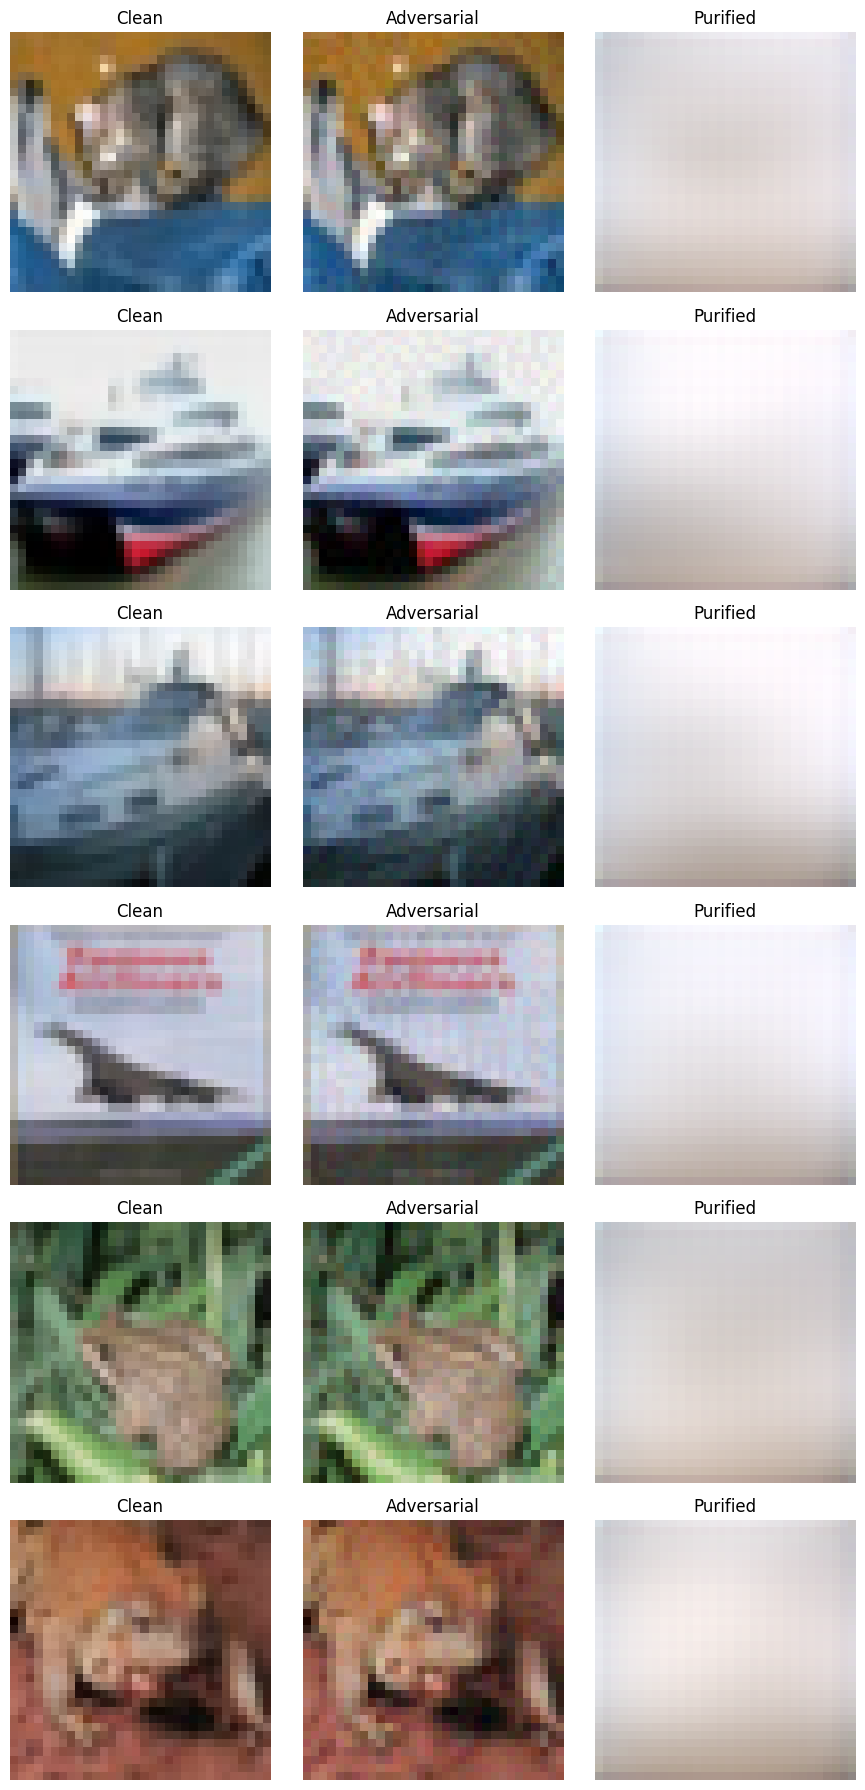

In [ ]:
import matplotlib.pyplot as plt

def show_triplet(model, loader, n=6, start_t=400, steps=50, pgd_params=None):
    model.eval()
    x, y = next(iter(loader))
    x, y = x[:n].to(device), y[:n].to(device)
    x_adv = pgd_attack(model, x, y, **(pgd_params or dict(eps=8/255, alpha=2/255, steps=10, random_start=True)))
    x_pur = purify_adversarial(ddpm, x_adv, start_t=start_t, steps=steps)

    imgs = torch.stack([to_pixel_space(x), to_pixel_space(x_adv), to_pixel_space(x_pur)], dim=1)  # [n,3,3,32,32]
    imgs = imgs.detach().cpu()

    fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
    for i in range(n):
        for j, title in enumerate(['Clean', 'Adversarial', 'Purified']):
            axes[i, j].imshow(imgs[i, j].permute(1, 2, 0))
            axes[i, j].set_title(title)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_triplet(clf, test_loader, n=6, start_t=400, steps=50)
